In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

In [3]:
#import health facilities data
hos = pd.read_excel("C:/Users/user/Downloads/ehealth-kenya-facilities-download-21102015.xls")

In [4]:
#extract data for Nairobi county
hos = hos.loc[hos['County'] == 'Nairobi']

In [5]:
#create new sub-counties 
hos['Sub County'] = np.where(hos.Constituency.str.contains("DAGORETTI"), "DAGORETTI",
                               np.where(hos.Constituency.str.contains("EMBAKASI"), "EMBAKASI",hos['Constituency']))
                                            

In [6]:
#import population data
pop = pd.read_csv("C:/Users/user/Downloads/distribution-of-persons-with-disability-by-type-of-disability-sex1-area-of-residence-county-and-.csv")

In [7]:
pop.columns = pop.iloc[0]
pop = pop[1:]
pop.columns.values[0] = 'Sub County'
pop = pop.replace(',','', regex=True)
pop = pop.replace('-',0, regex=True)
pop = pop.replace(np.nan,0, regex=True)

In [8]:
pop['Total Population'] = pop[[col for col in pop.columns if col == 'Total*']].astype(int).sum(axis=1)
pop['MTotal'] = pop[[col for col in pop.columns if col == 'Male']].astype(int).sum(axis=1)
pop['FTotal'] = pop[[col for col in pop.columns if col == 'Female']].astype(int).sum(axis=1)

In [9]:
#list of sub-counties of interest
subcounties = ['MATHARE', "LANG'ATA", 'KIBRA', 'STAREHE', 'WESTLANDS',
       'DAGORETTI', 'EMBAKASI', 'RUARAKA', 'ROYSAMBU', 'KAMUKUNJI',
       'MAKADARA', 'KASARANI']

In [10]:
#extract population data for Nairobi county
pop = pop.loc[pop['Sub County'].isin(subcounties)]

In [11]:
pop.head()

,Sub County,Total*,Male,Female,Total*,Male,Female,Total*,Male,Female,...,Female,Total*,Male,Female,Total*,Male,Female,Total Population,MTotal,FTotal
385,DAGORETTI,2074,858,1216,596,313,283,1720,676,1044,...,434,552,274,278,501,293,208,37668,16890,20778
386,EMBAKASI,3431,1461,1969,919,448,471,2084,937,1147,...,547,885,462,423,1030,592,438,56298,26322,29970
387,KAMUKUNJI,1245,519,725,364,170,194,1058,455,603,...,312,411,193,218,395,204,191,24090,10626,13458
388,KASARANI,3015,1227,1788,818,389,429,2194,997,1196,...,563,919,434,483,911,509,401,53424,24228,29160
389,KIBRA,987,434,553,290,146,144,713,289,423,...,206,243,126,117,295,169,126,17346,7926,9414


In [12]:
hos.head()

,Facility Code,Facility Name,Province,County,District,Division,Type,Owner,Location,Sub Location,...,OPD,OUTREACH,PMTCT,RAD/XRAY,RHTC/RHDC,TB DIAG,TB LABS,TB TREAT,YOUTH,Sub County
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MATHARE
7,13043,7Kr Mrs Health Centre,Nairobi,Nairobi,Langata,Lang'ata,Health Centre,Armed Forces,Mugumoini,Mugumoini,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LANG'ATA
10,20346,AAR Adams Health Centre,Nairobi,Nairobi,Kibra,Woodly,Medical Clinic,Private Practice - General Practitioner,Woodly,Woodly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KIBRA
11,12861,AAR City Centre Clinic,Nairobi,Nairobi,Starehe,Starehe,Medical Clinic,Private Enterprise (Institution),Central Business District,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STAREHE
12,16796,AAR Clinic Sarit Centre (Westlands),Nairobi,Nairobi,Westlands,Parklands,Medical Clinic,Private Enterprise (Institution),Parklands,Upper Parklands,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WESTLANDS


In [13]:
#summarize data
beds = hos.groupby('Sub County').agg({'Beds':'sum','Facility Code':'count'})
pop2 = pop.loc[:, ['Sub County','Total Population']]

In [14]:
#merge datasets
merged = pd.merge(beds, pop2, on='Sub County', how='inner')

In [15]:
#calculate number of beds per 1,000 PWD
merged['BPP'] = (merged['Beds']*1000)/merged['Total Population']

In [16]:
merged.replace('\'','', regex=True, inplace=True) 
merged['BPP'] = merged['BPP'].round(2)

In [17]:
#import geometric data for Kenya
kenya = gpd.read_file("C:/Users/user/Downloads/ken_adm_iebc_20191031_shp/ken_admbnda_adm2_iebc_20191031.shp")
kenya['ADM2_EN'] = kenya['ADM2_EN'].str.upper()
nairobi = kenya.loc[kenya['ADM1_EN'] == 'Nairobi'] #extract geometic data for Nairobi county
nairobi['ADM2_EN2'] = np.where(nairobi.ADM2_EN.str.contains("EMBAKASI"), "EMBAKASI",
                               np.where(nairobi.ADM2_EN.str.contains("DAGORETTI"), "DAGORETTI",nairobi['ADM2_EN'] ))
nairobi = nairobi.loc[:, ['ADM2_EN2','geometry']]
nai = nairobi.dissolve(by='ADM2_EN2', aggfunc='sum') #create geometric data for sub-counties of interest

C:\Users\user\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
#merge geometric data with combined population data
pop_subcounty = nai.merge(merged, left_on="ADM2_EN2", right_on="Sub County", how="left")
pop_subcounty['coords'] = pop_subcounty['geometry'].apply(lambda x: x.centroid.coords[:])
pop_subcounty['coords'] = [coords[0] for coords in pop_subcounty['coords']]
pop_subcounty['Beds'] = pop_subcounty['Beds'].replace(np.nan,0, regex=True)
pop_subcounty['Total Population'] = pop_subcounty['Total Population'].replace(np.nan,0, regex=True)
pop_subcounty['BPP'] = pop_subcounty['BPP'].replace(np.nan,0, regex=True)

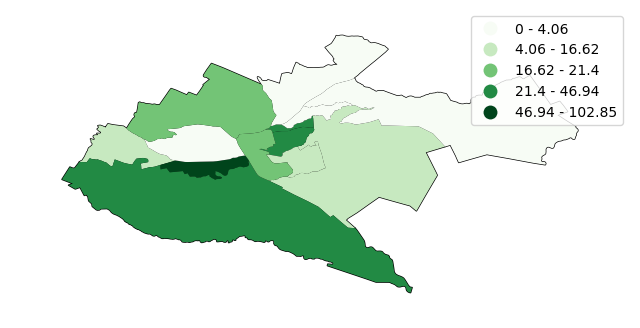

In [20]:
#plot number of beds per 1,000 PWD by sub-county
ax = gplt.polyplot(nai, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  pop_subcounty,
  hue="BPP",
  linewidth=1,
  cmap="Greens",
  legend=True,
  scheme="FisherJenks",
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)
#print sub-county label
#for _, row in pop_subcounty.iterrows():

#  hue = round(row['BPP'],2)
  
#  plt.text(s=row['Sub County'], x = row['coords'][0], y = row['coords'][1],
#           horizontalalignment='center', fontdict = {'weight': 'bold', 'size': 8})
plt.savefig('beds_per_one_thousand_nairobi.jpg')

<GeoAxes: >

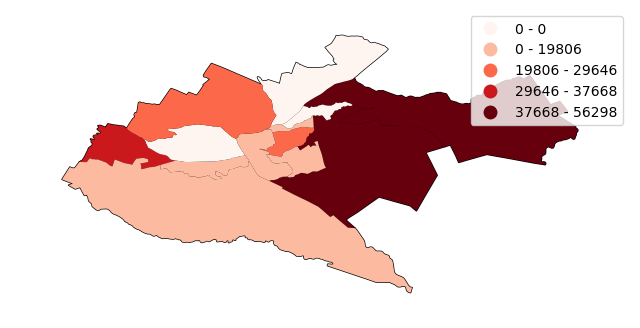

In [21]:
#plot PWD population distribution
ax = gplt.polyplot(nai, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  pop_subcounty,
  hue="Total Population",
  linewidth=1,
  cmap="Reds",
  legend=True,
  scheme="FisherJenks",
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)